In [89]:
from utils.utils import load_pipe_from_path

pipe = load_pipe_from_path(None, device='cpu')
vae = pipe.vae

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 5877.54it/s]
ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [100]:
import training_scripts.LITS17Dataset
from importlib import reload
reload(training_scripts.LITS17Dataset)
from training_scripts.LITS17Dataset import LITS17Dataset

ds = LITS17Dataset(
    "/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/imagesTr",
    "/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/labelsTr",
    "segmentation map of spleen",
    organ="spleen",
    tokenizer=None,
    size=512,
    path_slices_for_segmap="/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/labelsTr_slices.pkl",
    path_slices_for_vol="/disk4/Lev/Projects/diffusion_finetuning/data/MSD/Task09_Spleen/imagesTr_slices.pkl",
    resize=True,
    center_crop=True,
    h_flip=False,
    color_jitter=False,
)

center crop


In [101]:
# create ct emebddings and segmap embeddings
import torch
ct_embeddings = []
seg_embeddings = []

for i in range(min(1, len(ds))):
    ct = [ds[i]['instance_image']]
    seg = [ds[i]['instance_segmap_image']]
    ct = torch.stack(ct).to(vae.device, dtype=torch.float32)
    seg = torch.stack(seg).to(vae.device, dtype=torch.float32)
    ct_embeddings.append(vae.encode(ct).latent_dist.sample().detach().numpy())
    seg_embeddings.append(vae.encode(seg).latent_dist.sample().detach().numpy())

In [102]:
mult_embeds = [item + item2 for item, item2 in zip(ct_embeddings, seg_embeddings)]

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming your embeddings are stored in two numpy arrays, one for each list
def visualize_embeddings(embeddings_1, embeddings_2, title1='list1', title2='list2'):
    # Combine the two lists of embeddings into one array
    all_embeddings = np.concatenate((embeddings_1, embeddings_2), axis=0)

    # Reshape the embeddings to 2D arrays
    all_embeddings = all_embeddings.reshape(all_embeddings.shape[0], -1)

    # Perform PCA to reduce the dimensionality
    pca = PCA(n_components=10)
    all_embeddings_pca = pca.fit_transform(all_embeddings)

    # Perform t-SNE to further reduce the dimensionality to 2 dimensions
    tsne = TSNE(perplexity=5, n_components=2, random_state=42)
    all_embeddings_tsne = tsne.fit_transform(all_embeddings_pca)

    # Plot the embeddings
    plt.scatter(all_embeddings_tsne[:len(embeddings_1), 0], all_embeddings_tsne[:len(embeddings_1), 1], c='b', label=title1)
    plt.scatter(all_embeddings_tsne[len(embeddings_1):, 0], all_embeddings_tsne[len(embeddings_1):, 1], c='r', label=title2)
    plt.legend()
    plt.show()


In [94]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming your embeddings are stored in two numpy arrays, one for each list
def visualize_embeddings3(embeddings_1, embeddings_2, embeddings_3, title1='list1', title2='list2', title3='list3'):
    # Combine the two lists of embeddings into one array
    all_embeddings = np.concatenate((embeddings_1, embeddings_2, embeddings_3), axis=0)

    # Reshape the embeddings to 2D arrays
    all_embeddings = all_embeddings.reshape(all_embeddings.shape[0], -1)

    # Perform PCA to reduce the dimensionality
    pca = PCA(n_components=10)
    all_embeddings_pca = pca.fit_transform(all_embeddings)

    # Perform t-SNE to further reduce the dimensionality to 2 dimensions
    tsne = TSNE(perplexity=5, n_components=2, random_state=42)
    all_embeddings_tsne = tsne.fit_transform(all_embeddings_pca)

    # Plot the embeddings
    plt.scatter(all_embeddings_tsne[:len(embeddings_1), 0], all_embeddings_tsne[:len(embeddings_1), 1], c='b', label=title1)
    plt.scatter(all_embeddings_tsne[len(embeddings_1):len(embeddings_1) + len(embeddings_2), 0], all_embeddings_tsne[len(embeddings_1):len(embeddings_1) + len(embeddings_2), 1], c='r', label=title2)
    plt.scatter(all_embeddings_tsne[len(embeddings_1) + len(embeddings_2):, 0], all_embeddings_tsne[len(embeddings_1) + len(embeddings_2):, 1], c='g', label=title3)
    plt.legend()
    plt.show()


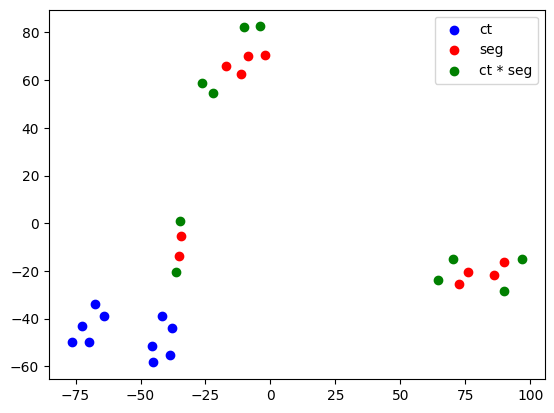

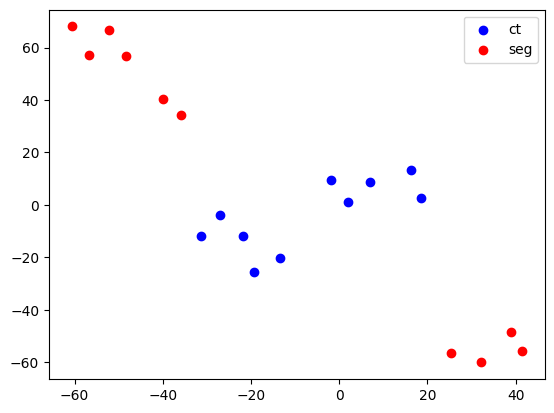

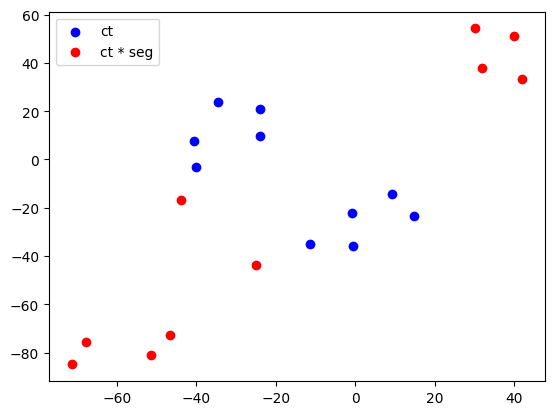

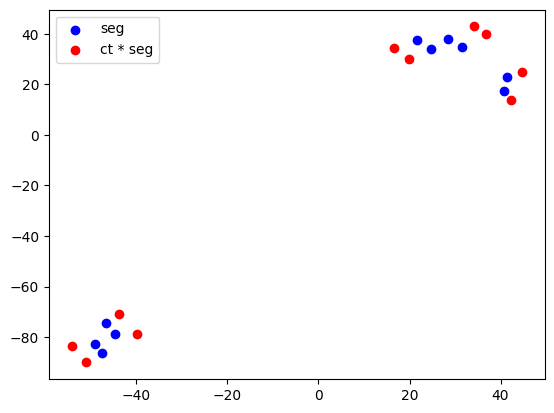

In [95]:
visualize_embeddings3(ct_embeddings, seg_embeddings, mult_embeds, title1='ct', title2='seg', title3='ct * seg')
visualize_embeddings(ct_embeddings, seg_embeddings, title1='ct', title2='seg')
visualize_embeddings(ct_embeddings, mult_embeds, title1='ct', title2='ct * seg')
visualize_embeddings(seg_embeddings, mult_embeds, title1='seg', title2='ct * seg')

In [96]:
def decode_embedding(vae, embed):
    dec = vae.decode(embed).sample
    return dec

In [106]:
dec = decode_embedding(vae, torch.from_numpy(mult_embeds[0]))
ct_dec = decode_embedding(vae, torch.from_numpy(ct_embeddings[0]))
seg_dec = decode_embedding(vae, torch.from_numpy(seg_embeddings[0]))

In [98]:
def plot_decoded_images(dec, ct, seg):
    if dec.shape[0] == 1:
        dec = dec.squeeze()
    if ct.shape[0] == 1:
        ct = ct.squeeze()
    if seg.shape[0] == 1:
        seg = seg.squeeze()
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(ct.detach().numpy().transpose(1, 2, 0), cmap='jet')
    ax[1].imshow(seg.detach().numpy().transpose(1, 2, 0), cmap='jet')
    ax[2].imshow(dec.detach().numpy().transpose(1, 2, 0), cmap='jet')
    # plt.imshow(dec.detach().numpy().transpose(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


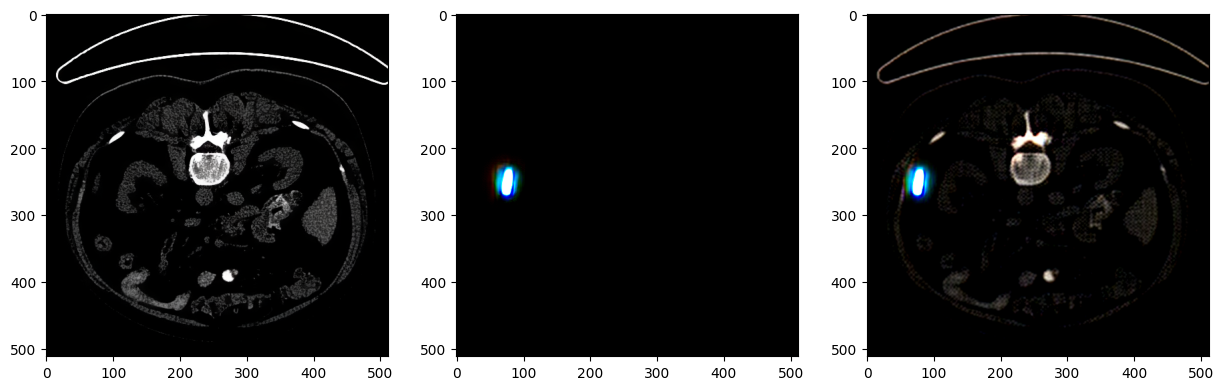

In [107]:
plot_decoded_images(dec, ct_dec, seg_dec)